In [2]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [6]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [7]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [8]:
sns.set()

## Data Prep

### Read Synergy + CTG Data

In [9]:
s_df = pd.read_csv('nba_offense_plus_ctg.csv')
s_df.shape

(2860, 62)

Filter in players with 200+ playtype possessions

In [10]:
# s_df = s_df[s_df['Overall_Poss'] >= 200]
# s_df.shape

### Read BBR Data

In [11]:
bbr_df = pd.read_csv('bbr_nba_stats.csv')
bbr_df.shape

(2323, 39)

In [13]:
bbr_df['mp'].min()

200

### Merge Synergy Data & BBR Data

In [14]:
s_df['Player_Alt'] = s_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                   .apply(lambda x: x.replace("'", ''))\
                                   .apply(lambda x: x.replace('.', ''))

In [15]:
bbr_df['player_alt_alt'] = bbr_df['player_alt'].apply(lambda x: x.replace(' ', ''))\
                                               .apply(lambda x: x.replace("'", ''))\
                                               .apply(lambda x: x.replace('.', ''))\
                                               .apply(lambda x: x.lower())

In [16]:
synergy_name_dict = {'kevinknoxii': 'kevinknox',
                     'danilogalinari': 'danilogallinari',
                     'louiswilliams': 'louwilliams',
                     'eneskanter': 'enesfreedom',
                     'terryrozieriii': 'terryrozier',
                     'cameronreddish': 'camreddish',
                     'jahilokafor': 'jahlilokafor',
                     'danuelhouse': 'danuelhousejr',
                     'alfarouqaminu': 'al-farouqaminu',
                     'nenehilario': 'nene',
                     'frankmason': 'frankmasoniii',
                     'larrynance': 'larrynancejr',
                     'wesleyiwundu': 'wesiwundu',
                     'robertwilliamsiii': 'robertwilliams',
                     'harrygilesiii': 'harrygiles',
                     'jamesennis': 'jamesennisiii',
                     'mohamedbamba': 'mobamba',
                     'xaviertillman': 'xaviertillmansr',
                     'patrickbeverly': 'patrickbeverley',
                     'malcomdelaney': 'malcolmdelaney',
                     'marcusmorrissr': 'marcusmorris',
                     'nicolasclaxton': 'nicclaxton',
                     'juanhernangomez': 'juanchohernangomez',
                     'guillermohernangomez': 'willyhernangomez',
                     'timothéluwawu-cabarrot': 'timotheluwawu-cabarrot',
                     'nahshonhyland': 'boneshyland',
                     'derrickwaltonjr': 'derrickwalton',
                     'ishmailwainright': 'ishwainright',
                     'johnnyobryantiii': 'johnnyobryant'}

In [17]:
s_df['Player_Alt'] = s_df['Player_Alt']\
                     .apply(lambda x: synergy_name_dict.get(x, x))

In [18]:
df = s_df.merge(bbr_df, how='right', 
                left_on=['Player_Alt', 'Team', 'Season'],
                right_on=['player_alt_alt', 'team', 'Season'])
df = df[~df['player_alt_alt'].isna()].reset_index().drop('index', axis=1)
df.shape

(2323, 102)

In [19]:
# check 
df[['Player_Alt', 'Team', 'Season']].drop_duplicates().shape

(2323, 3)

## Clustering

### Functions

In [20]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 12))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.95, 2, 11, color='red', linestyle='--')
    plt.xlabel('Number of Components (c)')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Results')

In [21]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                affinity='nearest_neighbors', 
                                random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method Showing the Optimal k')

### Define Weight Columns

In [22]:
playtypes = ['Isolation', 'P&R Ball Handler', 'Post-Up', 
             'P&R Roll Man', 'Spot Up', 'Off Screen', 
             'Hand Off', 'Cut', 
             'Offensive Rebounds', 
             'Transition']
playtype_weights = [f'{playtype}_Poss%'
                    for playtype in playtypes]

In [23]:
situations = ['Pick and Rolls Including Passes',
              'Isolations Including Passes',
              'Post-Ups Including Passes']
situation_weights = [f'{situation}_On_Court%'
                     for situation in situations]

In [24]:
shottypes = ['Catch and Shoot', 
             'At Rim',
             'Long (3 point jump shots)',
             'All Jump Shots off the Dribble'
            ]
shottype_weights = [f'{shottype}_FGA%' 
                    for shottype in shottypes]

In [25]:
weights = playtype_weights + shottype_weights + situation_weights
weights

['Isolation_Poss%',
 'P&R Ball Handler_Poss%',
 'Post-Up_Poss%',
 'P&R Roll Man_Poss%',
 'Spot Up_Poss%',
 'Off Screen_Poss%',
 'Hand Off_Poss%',
 'Cut_Poss%',
 'Offensive Rebounds_Poss%',
 'Transition_Poss%',
 'Catch and Shoot_FGA%',
 'At Rim_FGA%',
 'Long (3 point jump shots)_FGA%',
 'All Jump Shots off the Dribble_FGA%',
 'Pick and Rolls Including Passes_On_Court%',
 'Isolations Including Passes_On_Court%',
 'Post-Ups Including Passes_On_Court%']

### Check Correlations Among Weights

Text(0.5, 1.0, 'Correlations Among Weights in NBA (2017-2022)')

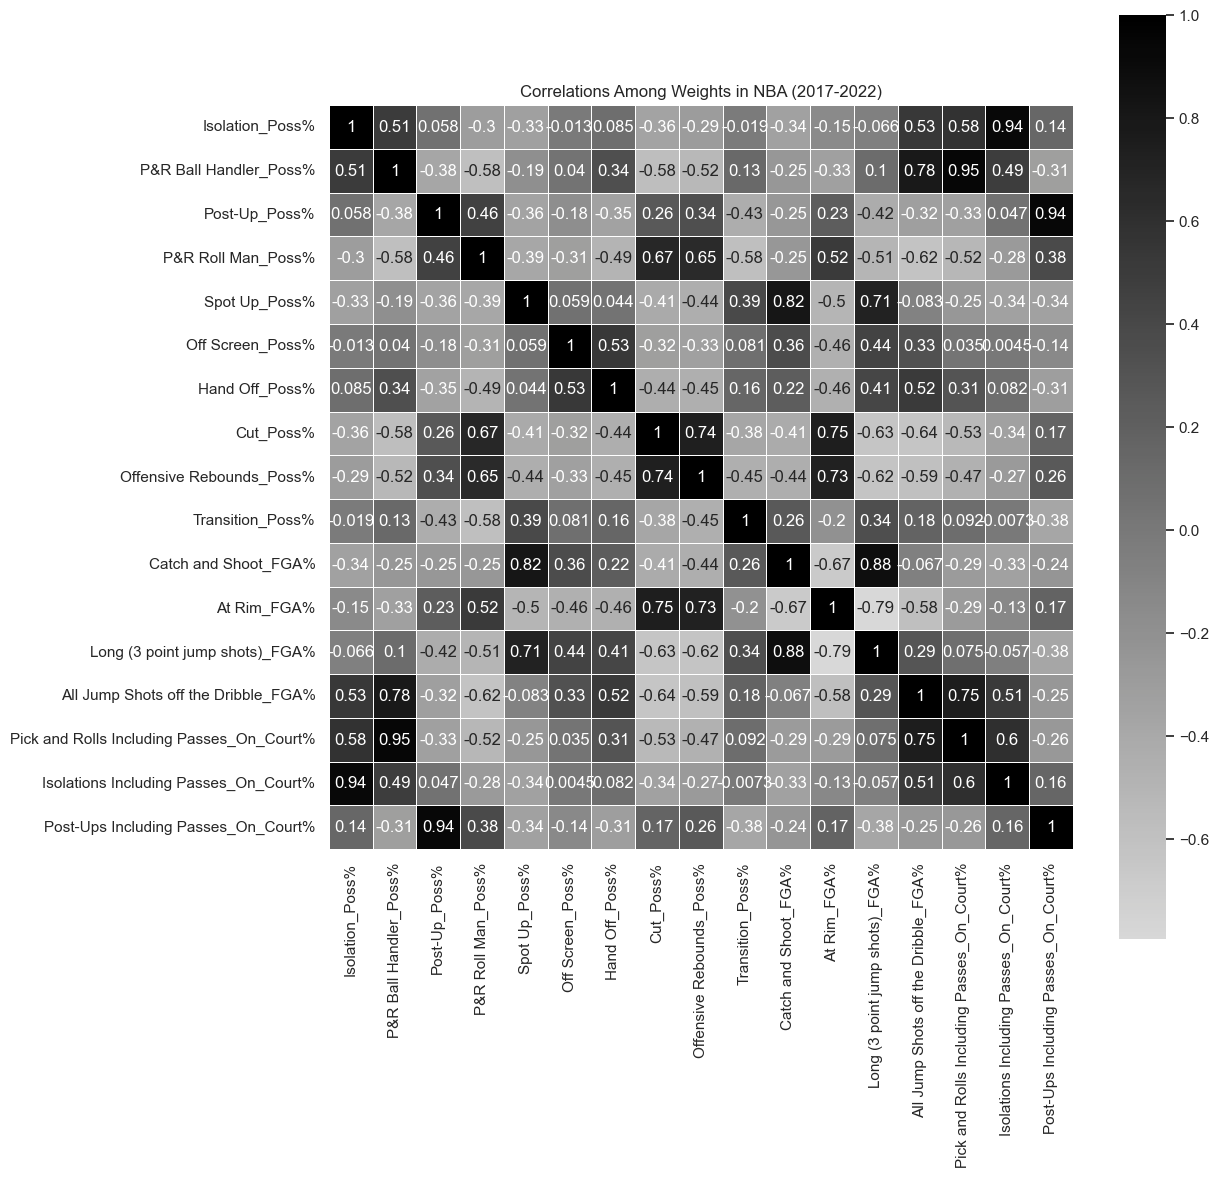

In [26]:
figsize(12, 8)
corr = df[weights].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,
            square=True, annot=True, linewidths=.5)
plt.title('Correlations Among Weights in NBA (2017-2022)')

### Reduce Dimensions with PCA

In [27]:
X = df[weights].copy()

Determine how many components reduce down to via PCA

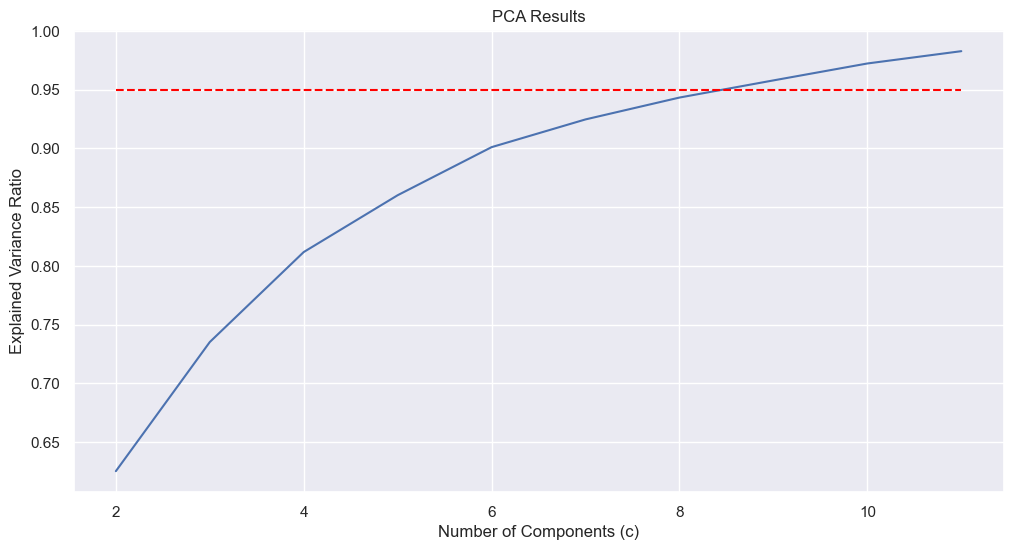

In [28]:
figsize(12, 6)
# pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pre_pca_pipe = StandardScaler()
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choosse 9

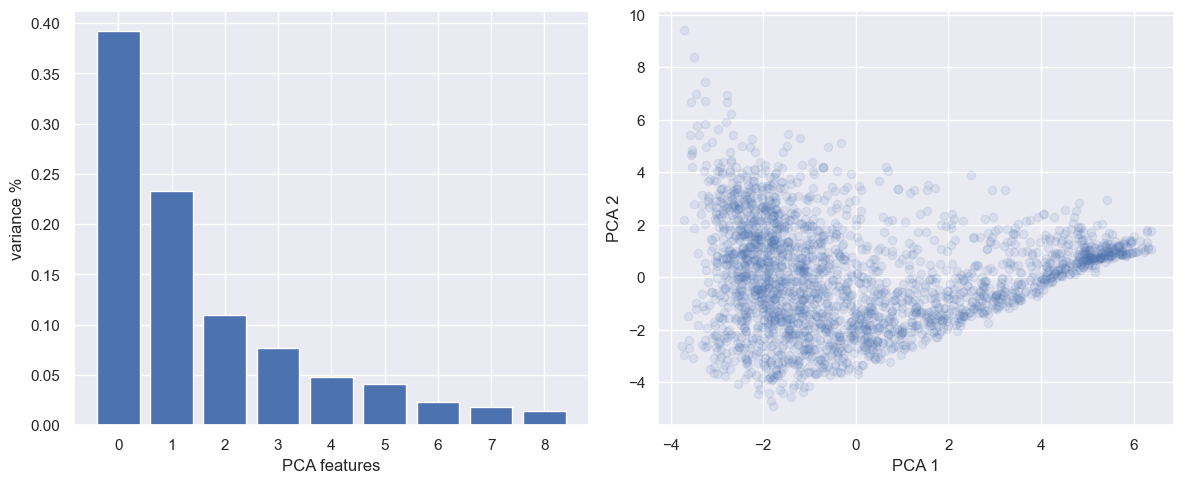

In [29]:
n_components = 9

pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=n_components)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 5)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [30]:
pre_cluster_scaler = StandardScaler()
X_transformed = pre_cluster_scaler.fit_transform(pca_components)

### Choose Optimal K

Determine # of clusters using silhouette score method

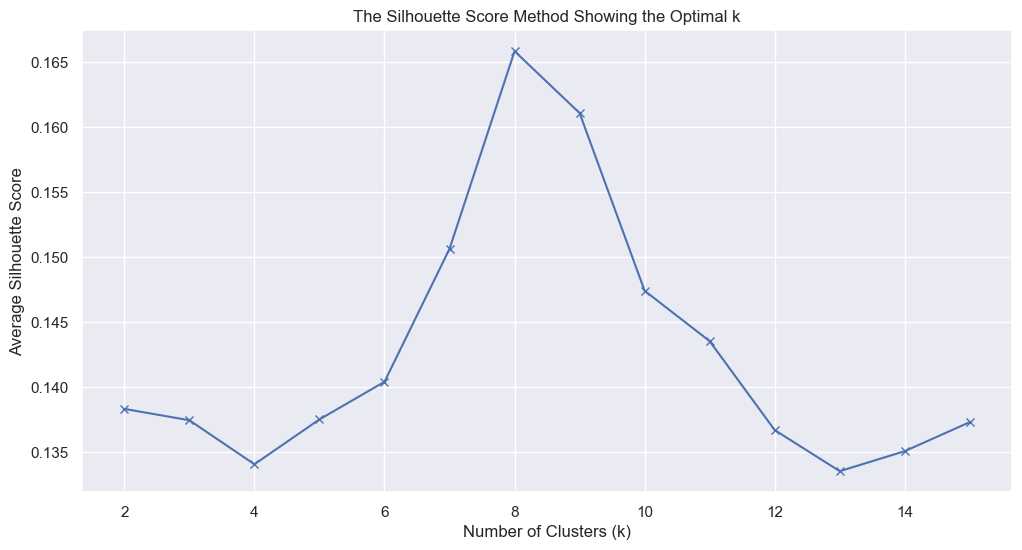

In [31]:
figsize(12, 6)
plot_silhouette_score(X_transformed)

### Clustering

In [32]:
# Choose k = 8
n_clusters = 8

sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors', 
                        random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, 
                                                  df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0    487
1    797
2    180
3    170
4    206
5    225
6    201
7     57
Name: Player, dtype: int64

## Results

### Functions

In [33]:
def plot_cluster_res_2d(df, cluster_col, col1, col2, cluster_dict):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, 
                    label=f'Cluster {cluster}: {cluster_dict[cluster]}', 
                    alpha=0.3)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [34]:
def show_cluster_res(df, cluster_col, weights=weights):
    cluster_res = df.groupby(cluster_col)[['usg_pct', 'obpm'] + weights]\
                    .mean().sort_values('obpm', ascending=False)
    cluster_cnt = Counter(df[cluster_col])
    cluster_res['obpm'] = cluster_res['obpm'].apply(lambda x: f'{x:.2f}')
    cluster_res['usg_pct'] = cluster_res['usg_pct'].apply(lambda x: f'{x:.1f}%')
    for col in cluster_res.columns:
        if '%' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

### Overview

In [35]:
show_cluster_res(df, 'player_cluster')

0       1       2       3  \
player_cluster                                  4       3       6       2   
usg_pct                                     26.0%   23.2%   18.8%   15.2%   
obpm                                         1.81    1.23   -0.57   -0.69   
Isolation_Poss%                            17.02%   4.56%   2.31%   0.46%   
P&R Ball Handler_Poss%                     26.87%   1.49%  12.75%   0.02%   
Post-Up_Poss%                               5.49%  24.91%   0.82%   5.84%   
P&R Roll Man_Poss%                          1.91%  18.61%   1.13%  23.25%   
Spot Up_Poss%                              17.84%  14.47%  33.00%   6.09%   
Off Screen_Poss%                            4.31%   1.65%  17.00%   0.07%   
Hand Off_Poss%                              4.81%   0.53%   7.48%   0.03%   
Cut_Poss%                                   3.18%  12.98%   4.19%  29.01%   
Offensive Rebounds_Poss%                    2.41%  11.52%   1.70%  26.53%   
Transition_Poss%                           16.18%   9.29%  19.63%   8.72%   
Catch and Shoot_FGA%                       20.40%  20.56%  46.85%   4.93%   
At Rim_FGA%                                31.68%  45.26%  22.03%  74.10%   
Long (3 point jump shots)_FGA%             36.03%  17.89%  56.75%   3.38%   
All Jump Shots off the Dribble_FGA%        31.59%   5.46%  22.47%   0.38%   
Pick and Rolls Including Passes_On_Court%  14.16%   0.62%   4.99%   0.01%   
Isolations Including Passes_On_Court%       6.21%   1.40%   0.73%   0.10%   
Post-Ups Including Passes_On_Court%         2.25%   8.02%   0.23%   1.27%   
#                                             206     170     201     180   

                                                4       5       6       7  
player_cluster                                  0       5       7       1  
usg_pct                                     20.5%   17.4%   17.1%   16.4%  
obpm                                        -0.71   -0.79   -1.12   -1.62  
Isolation_Poss%                             6.61%   1.05%   0.70%   2.74%  
P&R Ball Handler_Poss%                     39.71%   0.14%  10.42%   9.47%  
Post-Up_Poss%                               0.34%   6.86%   0.01%   2.22%  
P&R Roll Man_Poss%                          0.10%  28.96%   0.73%   3.49%  
Spot Up_Poss%                              23.49%  23.09%  31.51%  40.49%  
Off Screen_Poss%                            2.39%   0.40%  10.69%   2.89%  
Hand Off_Poss%                              5.75%   0.28%  22.01%   4.63%  
Cut_Poss%                                   2.11%  18.17%   4.33%   7.87%  
Offensive Rebounds_Poss%                    0.99%  10.85%   0.94%   4.87%  
Transition_Poss%                           18.10%  10.21%  18.66%  21.33%  
Catch and Shoot_FGA%                       23.30%  32.95%  48.82%  41.10%  
At Rim_FGA%                                31.86%  45.78%  20.48%  33.49%  
Long (3 point jump shots)_FGA%             37.25%  28.86%  59.33%  46.78%  
All Jump Shots off the Dribble_FGA%        30.05%   2.54%  23.85%  14.49%  
Pick and Rolls Including Passes_On_Court%  17.32%   0.05%   3.95%   3.34%  
Isolations Including Passes_On_Court%       2.13%   0.25%   0.24%   0.75%  
Post-Ups Including Passes_On_Court%         0.14%   1.73%   0.01%   0.61%  
#                                             487     225      57     797

- Ballhandler: 4 & 0
- Big: 3 & 2 & 5
- Wing: 6 & 7 & 1

In [36]:
cluster_dict = {4: 'Ballhandler', 0: 'Ballhandler',
                3: 'Big', 2: 'Big', 5: 'Big',
                6: 'Wing', 7: 'Wing', 1: 'Wing'}

In [37]:
def color_cluster(val, cluster_dict=cluster_dict):
    if cluster_dict[val] == 'Ballhandler':
        return '#AB3B3A'
    elif cluster_dict[val] == 'Wing':
        return '#2E5C6E'
    elif cluster_dict[val] == 'Big':
        return '#F7D94C'

In [38]:
def color_cluster_pandas(val, cluster_dict=cluster_dict):
    if val in cluster_dict.keys():
        color = color_cluster(val, cluster_dict=cluster_dict)
    else:
        color = 'white'
    return f'background-color: {color}' 

In [39]:
show_cluster_res(df, 'player_cluster')\
.style.applymap(color_cluster_pandas)

### Observations

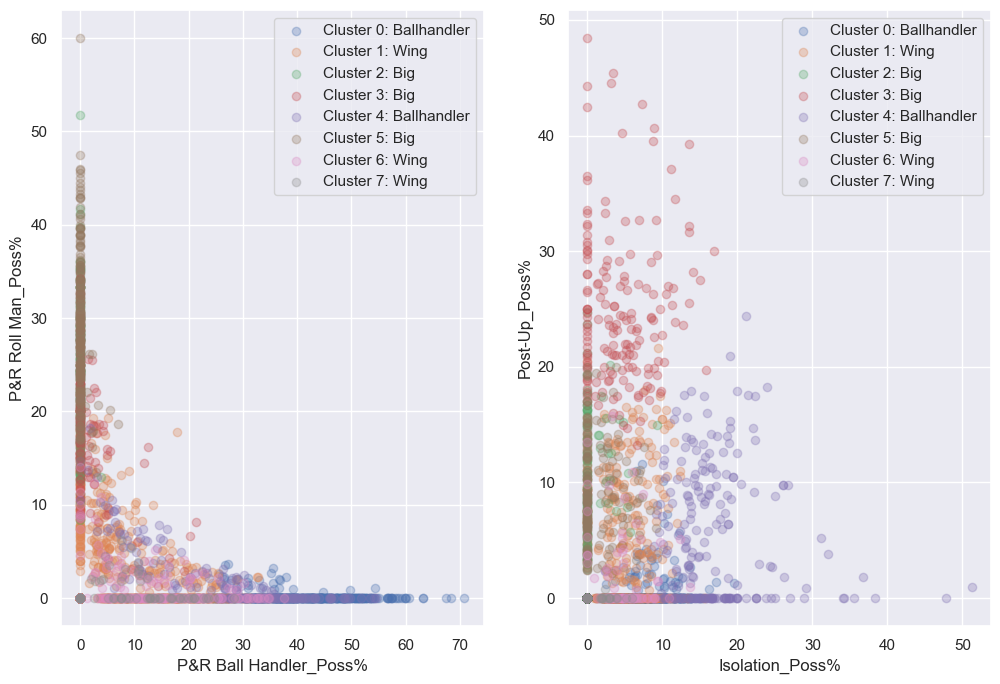

In [40]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='P&R Roll Man_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='Isolation_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)

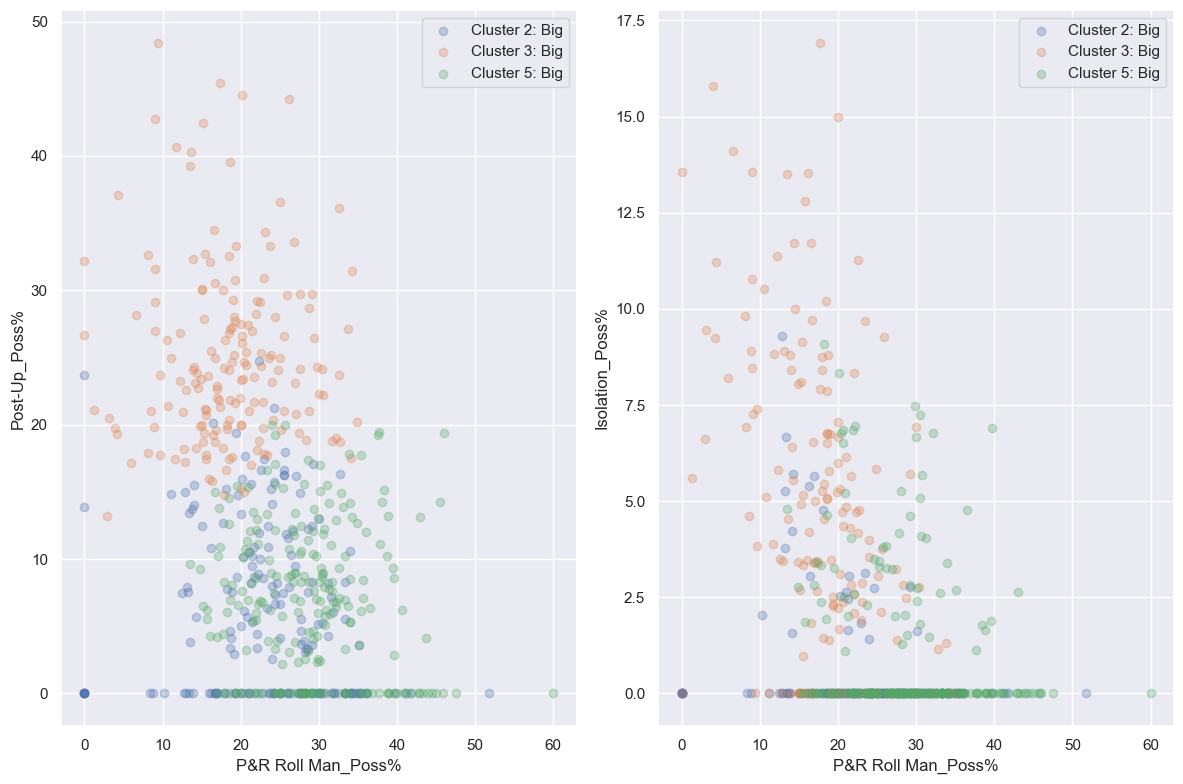

In [41]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

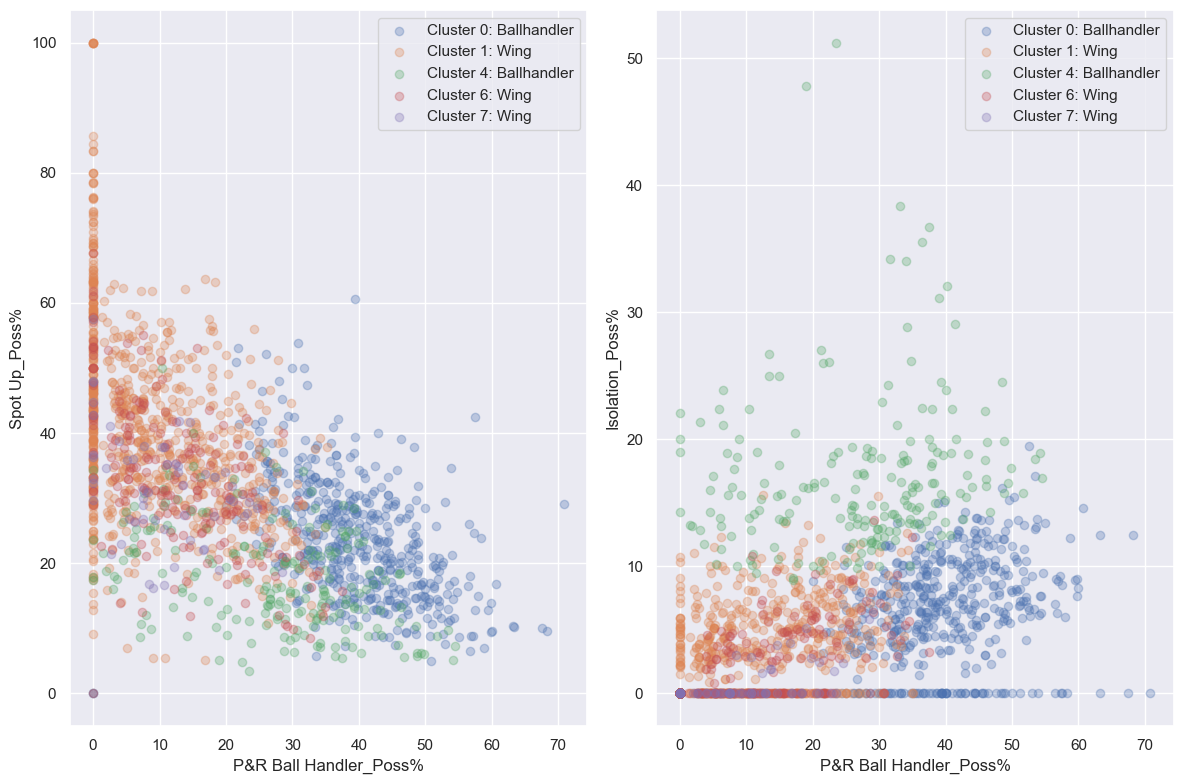

In [42]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Spot Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

### Distributions

Height & Weight

In [43]:
cluster_dict

{4: 'Ballhandler',
 0: 'Ballhandler',
 3: 'Big',
 2: 'Big',
 5: 'Big',
 6: 'Wing',
 7: 'Wing',
 1: 'Wing'}

In [44]:
cluster_order = [4, 0, 6, 7, 1, 5, 3, 2]

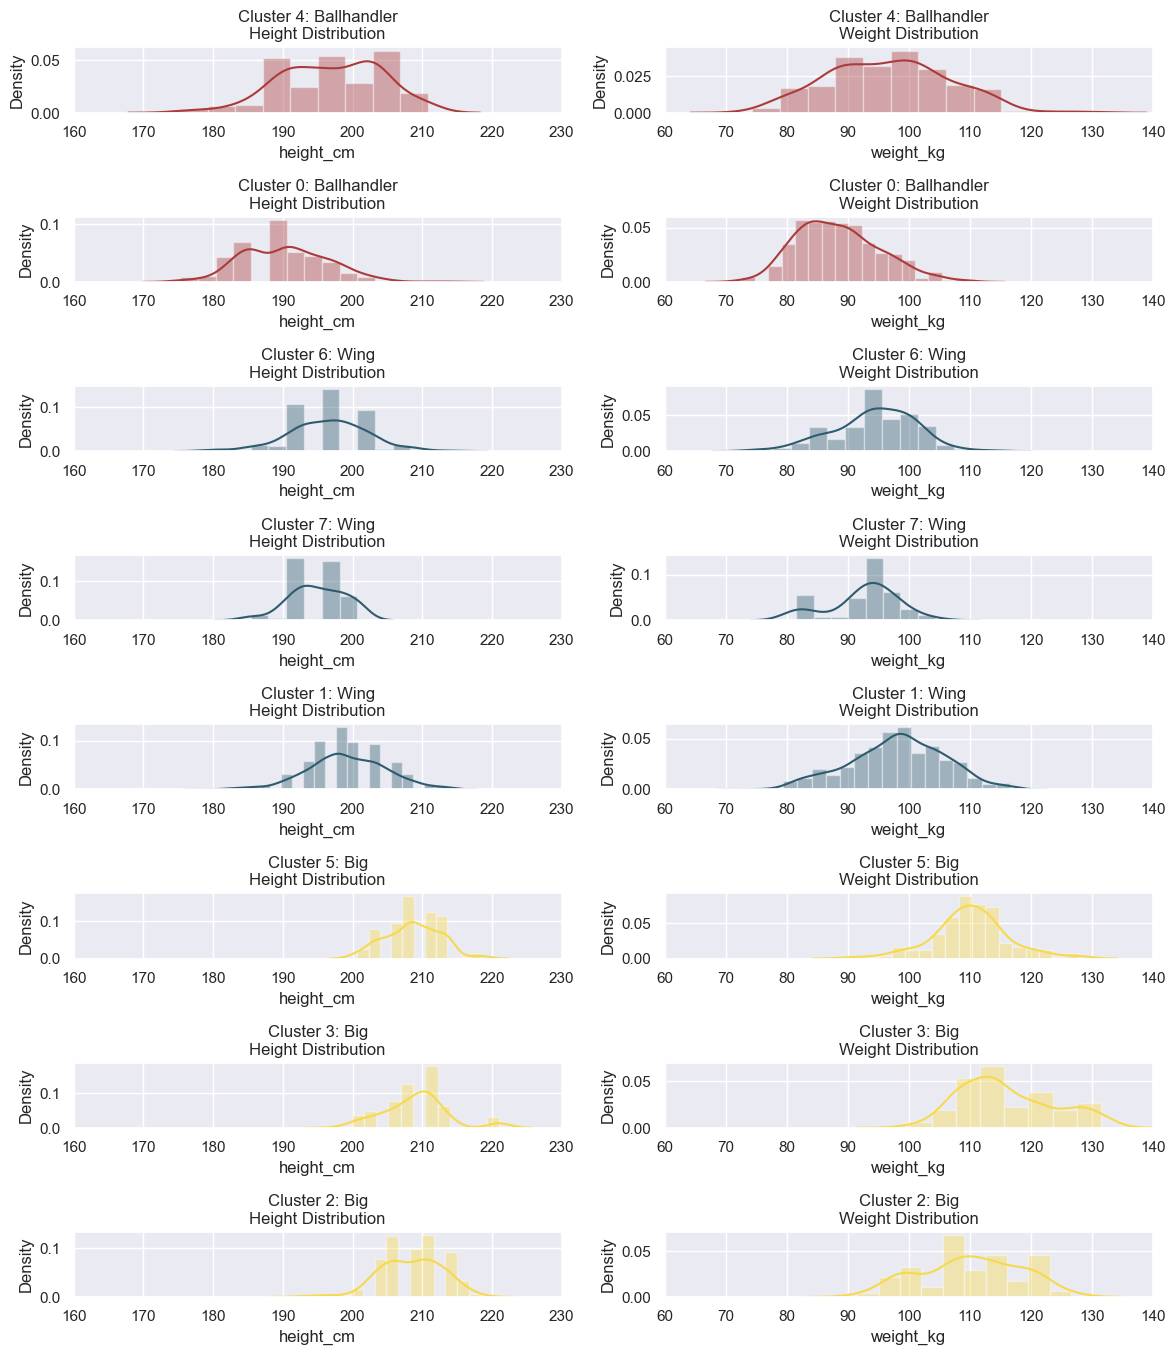

In [45]:
figsize(12, 20)
for idx, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, idx*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['height_cm'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nHeight Distribution')
    plt.xlim(160, 230)
    plt.subplot(12, 2, idx*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['weight_kg'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nWeight Distribution')
    plt.xlim(60, 140)
plt.tight_layout()

Usage & OBPM

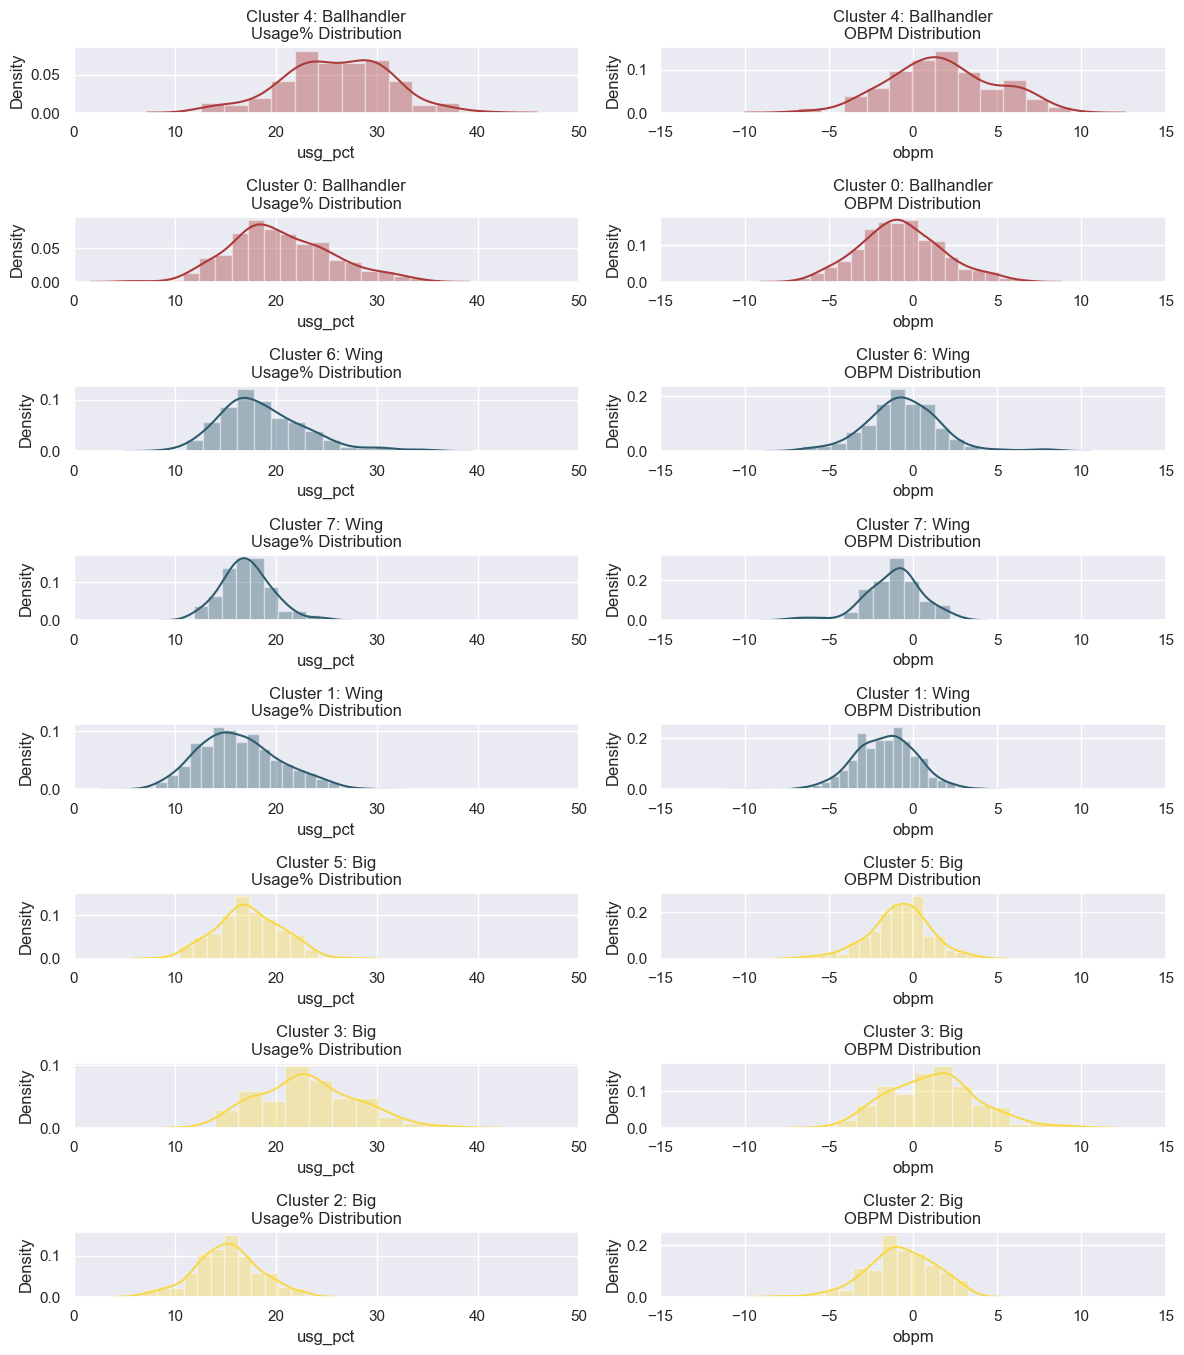

In [46]:
figsize(12, 20)
for i, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, i*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['usg_pct'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nUsage% Distribution')
    plt.xlim(0, 50)
    plt.subplot(12, 2, i*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['obpm'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nOBPM Distribution')
    plt.xlim(-15, 15)
plt.tight_layout()

### Top & Bottom Players by Cluster

In [57]:
def display_cluster_players(df, cluster_col, cluster_label):
    cols = ['Player', 'Season', 'Team', 'mp', 'obpm']
    best_10 = df[df[cluster_col] == cluster_label].sort_values('obpm', ascending=False)\
                                                  .head(10)[cols]\
                                                  .rename(columns={'Player': 'Best 10 Players'})\
                                                  .reset_index().drop('index', axis=1)
    worst_10 = df[df[cluster_col] == cluster_label].sort_values('obpm')\
                                                   .head(10)[cols]\
                                                   .rename(columns={'Player': 'Worst 10 Players'})\
                                                   .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

Ballhandlers

In [58]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 206


Best 10 Players     Season                    Team    mp  obpm  \
0           James Harden  2018-2019         Houston Rockets  2867   9.4   
1           James Harden  2017-2018         Houston Rockets  2551   8.5   
2         Damian Lillard  2019-2020  Portland Trail Blazers  2474   8.3   
3           James Harden  2019-2020         Houston Rockets  2483   8.1   
4  Giannis Antetokounmpo  2021-2022         Milwaukee Bucks  2204   7.6   
5         Damian Lillard  2020-2021  Portland Trail Blazers  2398   7.5   
6            Luka Doncic  2019-2020        Dallas Mavericks  2047   7.4   
7  Giannis Antetokounmpo  2019-2020         Milwaukee Bucks  1917   7.4   
8           LeBron James  2017-2018     Cleveland Cavaliers  3026   7.3   
9             Trae Young  2021-2022           Atlanta Hawks  2652   7.1   

  Worst 10 Players     Season                    Team    mp  obpm  
0      Theo Pinson  2019-2020           Brooklyn Nets   365  -6.8  
1    Miles McBride  2021-2022         New York Knicks   372  -5.5  
2    Markus Howard  2020-2021          Denver Nuggets   205  -5.5  
3    Austin Rivers  2018-2019      Washington Wizards   683  -4.1  
4       Trey Burke  2021-2022        Dallas Mavericks   441  -3.6  
5      Theo Pinson  2018-2019           Brooklyn Nets   211  -3.6  
6    Collin Sexton  2021-2022     Cleveland Cavaliers   316  -3.5  
7    Austin Rivers  2021-2022          Denver Nuggets  1480  -3.5  
8    Iman Shumpert  2017-2018     Cleveland Cavaliers   276  -3.4  
9      Harry Giles  2020-2021  Portland Trail Blazers   348  -3.2

In [59]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 487


Best 10 Players     Season                Team    mp  obpm Worst 10 Players  \
0    Kyrie Irving  2019-2020       Brooklyn Nets   658   6.7  Jerome Robinson   
1      Trae Young  2019-2020       Atlanta Hawks  2120   6.2      Tim Frazier   
2       Ja Morant  2021-2022   Memphis Grizzlies  1889   6.2    Killian Hayes   
3    Jimmy Butler  2020-2021          Miami Heat  1745   5.4  Justise Winslow   
4    Bradley Beal  2019-2020  Washington Wizards  2053   5.3   Jarrett Culver   
5      Trae Young  2020-2021       Atlanta Hawks  2125   5.3      Jacob Evans   
6    Kemba Walker  2018-2019   Charlotte Hornets  2863   5.2   Brad Wanamaker   
7    Tyreke Evans  2017-2018   Memphis Grizzlies  1607   4.9   Tyrone Wallace   
8    Kemba Walker  2019-2020      Boston Celtics  1742   4.9      Daishen Nix   
9     Zach Lavine  2020-2021       Chicago Bulls  2034   4.9   Isaiah Briscoe   

      Season                   Team   mp  obpm  
0  2020-2021     Washington Wizards  305  -6.9  
1  2021-2022          Orlando Magic  200  -6.4  
2  2020-2021        Detroit Pistons  670  -6.3  
3  2020-2021      Memphis Grizzlies  507  -6.2  
4  2021-2022      Memphis Grizzlies  338  -5.7  
5  2019-2020  Golden State Warriors  414  -5.7  
6  2021-2022         Indiana Pacers  293  -5.6  
7  2018-2019   Los Angeles Clippers  628  -5.6  
8  2021-2022        Houston Rockets  261  -5.4  
9  2018-2019          Orlando Magic  559  -5.4

Bigs

In [60]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 170


Best 10 Players     Season                    Team    mp  obpm  \
0        Nikola Jokic  2021-2022          Denver Nuggets  2476   9.2   
1        Nikola Jokic  2020-2021          Denver Nuggets  2488   9.1   
2         Joel Embiid  2021-2022      Philadelphia 76ers  2297   7.2   
3       Anthony Davis  2018-2019    New Orleans Pelicans  1850   7.1   
4  Karl-Anthony Towns  2019-2020  Minnesota Timberwolves  1187   7.0   
5         Joel Embiid  2020-2021      Philadelphia 76ers  1585   6.3   
6        Nikola Jokic  2018-2019          Denver Nuggets  2504   6.2   
7        Nikola Jokic  2019-2020          Denver Nuggets  2336   5.5   
8      Nikola Vucevic  2020-2021           Orlando Magic  1500   5.5   
9  Kristaps Porzingis  2021-2022      Washington Wizards   479   5.4   

      Worst 10 Players     Season                    Team    mp  obpm  
0         Zach Collins  2017-2018  Portland Trail Blazers  1045  -4.5  
1        James Wiseman  2020-2021   Golden State Warriors   836  -4.0  
2          Greg Monroe  2018-2019         Toronto Raptors   423  -3.5  
3          Harry Giles  2018-2019        Sacramento Kings   820  -3.4  
4          Joe Johnson  2017-2018         Houston Rockets   505  -3.3  
5          Robin Lopez  2019-2020         Milwaukee Bucks   958  -3.0  
6  Johnny O'Bryant III  2017-2018       Charlotte Hornets   379  -2.9  
7      Markieff Morris  2018-2019   Oklahoma City Thunder   387  -2.8  
8     DeMarcus Cousins  2021-2022          Denver Nuggets   431  -2.8  
9       Andre Drummond  2020-2021      Los Angeles Lakers   520  -2.7

In [61]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 180


Best 10 Players     Season                    Team    mp  obpm  \
0         Clint Capela  2018-2019         Houston Rockets  2249   3.3   
1       Brandon Clarke  2021-2022       Memphis Grizzlies  1246   3.1   
2          Rudy Gobert  2018-2019               Utah Jazz  2577   3.0   
3          Rudy Gobert  2021-2022               Utah Jazz  2120   2.9   
4  Robert Williams III  2020-2021          Boston Celtics   985   2.9   
5         Clint Capela  2020-2021           Atlanta Hawks  1898   2.7   
6    Willy Hernangomez  2017-2018       Charlotte Hornets   262   2.7   
7        Jarrett Allen  2021-2022     Cleveland Cavaliers  1809   2.7   
8     Hassan Whiteside  2019-2020  Portland Trail Blazers  2008   2.5   
9       Daniel Gafford  2020-2021      Washington Wizards   408   2.5   

     Worst 10 Players     Season                    Team    mp  obpm  
0        Norvel Pelle  2019-2020      Philadelphia 76ers   232  -7.8  
1      Bruno Fernando  2020-2021           Atlanta Hawks   226  -6.1  
2      Caleb Swanigan  2019-2020  Portland Trail Blazers   265  -5.5  
3        Reggie Perry  2020-2021           Brooklyn Nets   211  -5.3  
4        Kevon Looney  2019-2020   Golden State Warriors   262  -4.8  
5        Andrew Bogut  2017-2018      Los Angeles Lakers   216  -4.7  
6         Ian Mahinmi  2017-2018      Washington Wizards  1145  -4.6  
7            Ed Davis  2019-2020               Utah Jazz   303  -4.6  
8  Isaiah Hartenstein  2020-2021          Denver Nuggets   272  -4.3  
9    Anzejs Pasecniks  2019-2020      Washington Wizards   437  -4.1

In [62]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 225


Best 10 Players     Season                   Team    mp  obpm  \
0    Mike Muscala  2021-2022  Oklahoma City Thunder   592   3.8   
1    John Collins  2019-2020          Atlanta Hawks  1363   3.7   
2      Al Horford  2018-2019         Boston Celtics  1973   3.3   
3     Jalen Smith  2021-2022         Indiana Pacers   543   2.9   
4   Thomas Bryant  2019-2020     Washington Wizards  1147   2.9   
5    John Collins  2018-2019          Atlanta Hawks  1829   2.8   
6   Chris Boucher  2020-2021        Toronto Raptors  1453   2.7   
7      Jeff Green  2019-2020        Houston Rockets   407   2.5   
8  Brandon Clarke  2019-2020      Memphis Grizzlies  1300   2.4   
9    Clint Capela  2017-2018        Houston Rockets  2034   2.4   

     Worst 10 Players     Season                  Team   mp  obpm  
0        Isaiah Hicks  2017-2018       New York Knicks  240  -6.4  
1      Dewayne Dedmon  2019-2020      Sacramento Kings  541  -6.3  
2         Jason Smith  2017-2018    Washington Wizards  285  -5.4  
3       Jordan Mickey  2017-2018            Miami Heat  284  -5.2  
4  Isaiah Hartenstein  2018-2019       Houston Rockets  221  -5.1  
5        Nicolo Melli  2020-2021  New Orleans Pelicans  241  -4.9  
6     Marquese Chriss  2018-2019   Cleveland Cavaliers  395  -4.6  
7      Dewayne Dedmon  2019-2020         Atlanta Hawks  233  -4.6  
8         D.J. Wilson  2019-2020       Milwaukee Bucks  363  -4.1  
9        Goga Bitadze  2019-2020        Indiana Pacers  471  -4.1

Wings

In [63]:
c = 6
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 201


Best 10 Players     Season                   Team    mp  obpm  \
0      Stephen Curry  2020-2021  Golden State Warriors  2152   8.3   
1      Stephen Curry  2017-2018  Golden State Warriors  1631   7.8   
2      Stephen Curry  2018-2019  Golden State Warriors  2331   7.1   
3      Stephen Curry  2021-2022  Golden State Warriors  2211   5.4   
4       Bradley Beal  2020-2021     Washington Wizards  2147   4.8   
5        Paul George  2019-2020   Los Angeles Clippers  1419   3.8   
6        Buddy Hield  2018-2019       Sacramento Kings  2615   3.5   
7  Bogdan Bogdanovic  2020-2021          Atlanta Hawks  1305   3.3   
8       Bradley Beal  2017-2018     Washington Wizards  2977   2.9   
9      Davis Bertans  2019-2020     Washington Wizards  1583   2.7   

  Worst 10 Players     Season                    Team    mp  obpm  
0    Elijah Hughes  2021-2022  Portland Trail Blazers   322  -6.6  
1    Rodney Purvis  2017-2018           Orlando Magic   290  -6.1  
2       Davon Reed  2017-2018            Phoenix Suns   242  -5.8  
3    Chris Chiozza  2021-2022   Golden State Warriors   372  -5.7  
4    Dillon Brooks  2018-2019       Memphis Grizzlies   330  -5.0  
5    Aaron Nesmith  2021-2022          Boston Celtics   574  -4.9  
6    Ryan Anderson  2018-2019            Phoenix Suns   278  -4.5  
7     Jordan Poole  2019-2020   Golden State Warriors  1274  -4.4  
8   Carsen Edwards  2019-2020          Boston Celtics   351  -4.4  
9  Jerome Robinson  2018-2019    Los Angeles Clippers   320  -4.2

In [64]:
c = 7
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 57


Best 10 Players     Season                Team    mp  obpm  \
0        JJ Redick  2018-2019  Philadelphia 76ers  2379   2.2   
1        JJ Redick  2017-2018  Philadelphia 76ers  2116   2.2   
2  Duncan Robinson  2019-2020          Miami Heat  2166   1.5   
3   Doug McDermott  2020-2021      Indiana Pacers  1619   1.4   
4  Wayne Ellington  2020-2021     Detroit Pistons  1012   1.1   
5      Gary Harris  2017-2018      Denver Nuggets  2304   1.0   
6  Wayne Ellington  2017-2018          Miami Heat  2041   1.0   
7   Reggie Bullock  2017-2018     Detroit Pistons  1732   0.7   
8      Bryn Forbes  2020-2021     Milwaukee Bucks  1354   0.4   
9    Evan Fournier  2020-2021      Boston Celtics   472   0.1   

   Worst 10 Players     Season                    Team    mp  obpm  
0       Jacob Evans  2018-2019   Golden State Warriors   204  -6.9  
1    Keljin Blevins  2021-2022  Portland Trail Blazers   349  -5.6  
2        Josh Green  2020-2021        Dallas Mavericks   445  -3.7  
3      Tyler Dorsey  2018-2019           Atlanta Hawks   251  -3.4  
4      Allen Crabbe  2019-2020           Atlanta Hawks   522  -3.1  
5     Terrence Ross  2017-2018           Orlando Magic   600  -2.8  
6     Avery Bradley  2017-2018         Detroit Pistons  1268  -2.8  
7       Gary Harris  2019-2020          Denver Nuggets  1780  -2.8  
8  Ignas Brazdeikis  2021-2022           Orlando Magic   536  -2.7  
9    Justin Holiday  2021-2022        Sacramento Kings   641  -2.6

In [65]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 797


Best 10 Players     Season                    Team    mp  obpm  \
0    Danilo Gallinari  2019-2020   Oklahoma City Thunder  1834   4.1   
1  Michael Porter Jr.  2020-2021          Denver Nuggets  1912   4.0   
2      Christian Wood  2019-2020         Detroit Pistons  1325   3.5   
3        Jaylen Brown  2020-2021          Boston Celtics  1999   3.2   
4         Bam Adebayo  2020-2021              Miami Heat  2143   2.9   
5       Tobias Harris  2020-2021      Philadelphia 76ers  2014   2.9   
6           Josh Hart  2021-2022  Portland Trail Blazers   417   2.8   
7        Jamal Murray  2020-2021          Denver Nuggets  1704   2.7   
8        Desmond Bane  2021-2022       Memphis Grizzlies  2266   2.5   
9     Sean Kilpatrick  2017-2018           Chicago Bulls   214   2.5   

  Worst 10 Players     Season                   Team   mp  obpm  
0        Josh Hall  2020-2021  Oklahoma City Thunder  336  -9.7  
1   Aaron Harrison  2017-2018       Dallas Mavericks  233  -6.8  
2       Wes Iwundu  2020-2021   New Orleans Pelicans  251  -6.8  
3        KZ Okpala  2020-2021             Miami Heat  447  -6.5  
4    Deonte Burton  2019-2020  Oklahoma City Thunder  356  -6.3  
5    Avery Bradley  2020-2021        Houston Rockets  391  -6.2  
6    Iman Shumpert  2019-2020          Brooklyn Nets  241  -6.2  
7     Dwayne Bacon  2019-2020      Charlotte Hornets  687  -5.9  
8      Isaac Bonga  2020-2021     Washington Wizards  432  -5.8  
9    Edmond Sumner  2018-2019         Indiana Pacers  210  -5.8

### Edge Cases

In [66]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

Player player_cluster        player_cluster_adj  n_cluster
48       Ben Simmons      {0, 1, 3}  {Ballhandler, Wing, Big}          3
69       Bruce Brown      {0, 1, 2}  {Big, Wing, Ballhandler}          3
87   Carmelo Anthony      {1, 3, 4}  {Ballhandler, Wing, Big}          3
245  Harrison Barnes      {1, 3, 4}  {Ballhandler, Wing, Big}          3
325     Jerami Grant      {1, 4, 5}  {Ballhandler, Wing, Big}          3

In [67]:
temp[(temp['n_cluster'] == 2) & 
     (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

Player player_cluster  player_cluster_adj  n_cluster
152    DeMarcus Cousins      {3, 4, 5}  {Big, Ballhandler}          2
196            Ed Davis         {0, 2}  {Big, Ballhandler}          2
246         Harry Giles      {3, 4, 5}  {Ballhandler, Big}          2
383       Julius Randle         {3, 4}  {Big, Ballhandler}          2
394  Karl-Anthony Towns         {3, 4}  {Big, Ballhandler}          2
694      Tyson Chandler         {0, 2}  {Ballhandler, Big}          2
722     Zion Williamson         {3, 4}  {Big, Ballhandler}          2

## Visualization via TSNE

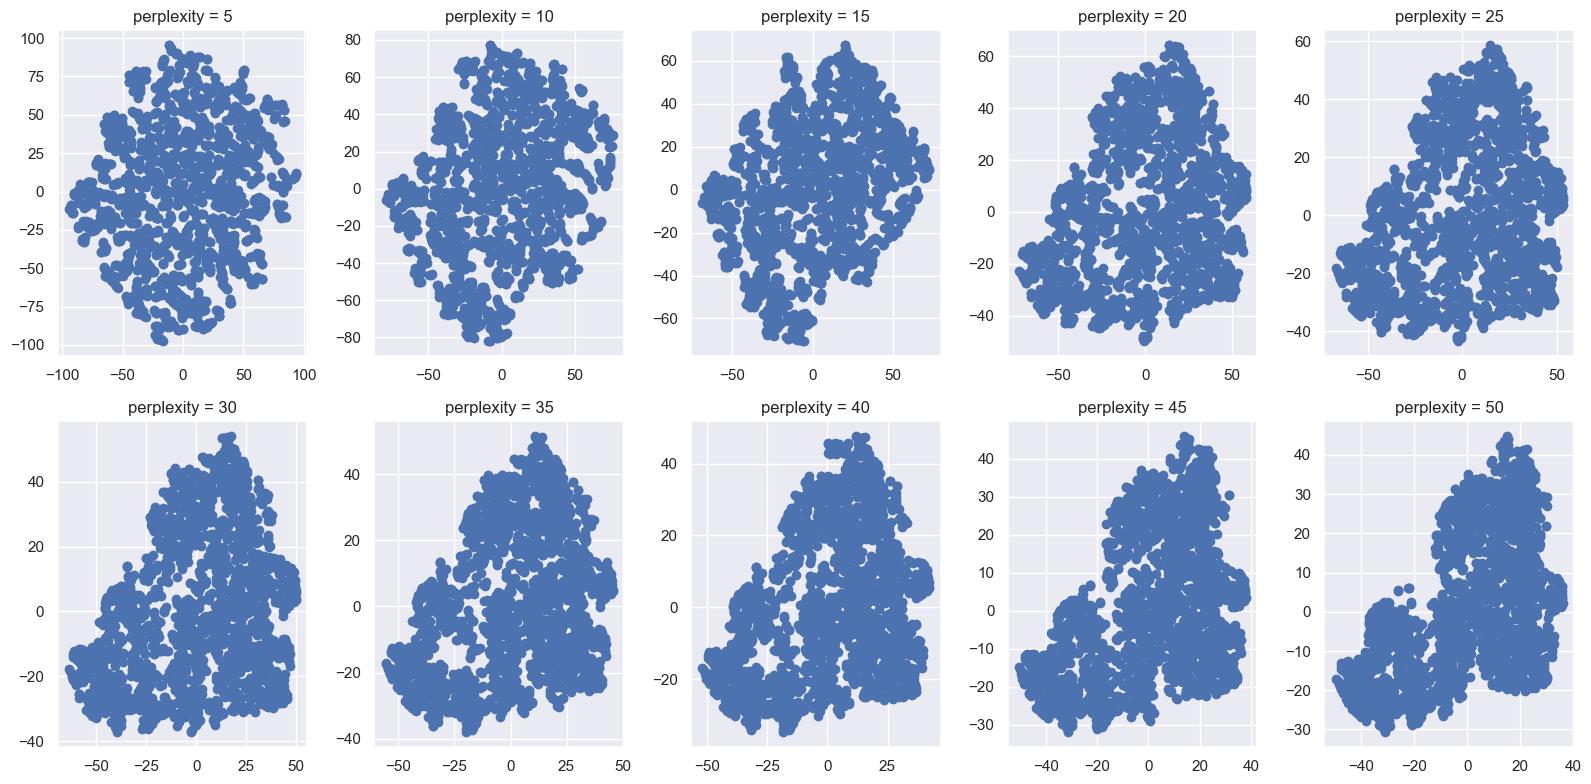

In [69]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, random_state=0)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [74]:
perplexity = 30
tsne = TSNE(perplexity=perplexity, random_state=0)
X_tsne = tsne.fit_transform(X_transformed)

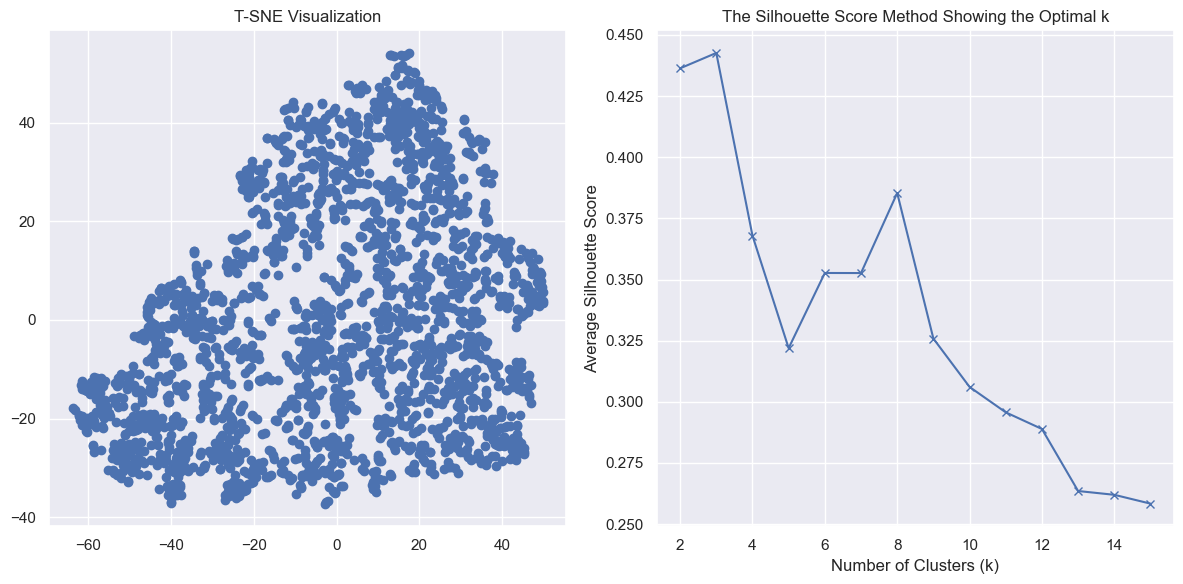

In [75]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [76]:
df_tsne = df.copy()
n_clusters_tsne = 8

sc_tsne = SpectralClustering(n_clusters=n_clusters_tsne, 
                             affinity='nearest_neighbors', 
                             random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

In [79]:
upper_limit = 90
lower_limit = -60
loc = 'upper left'

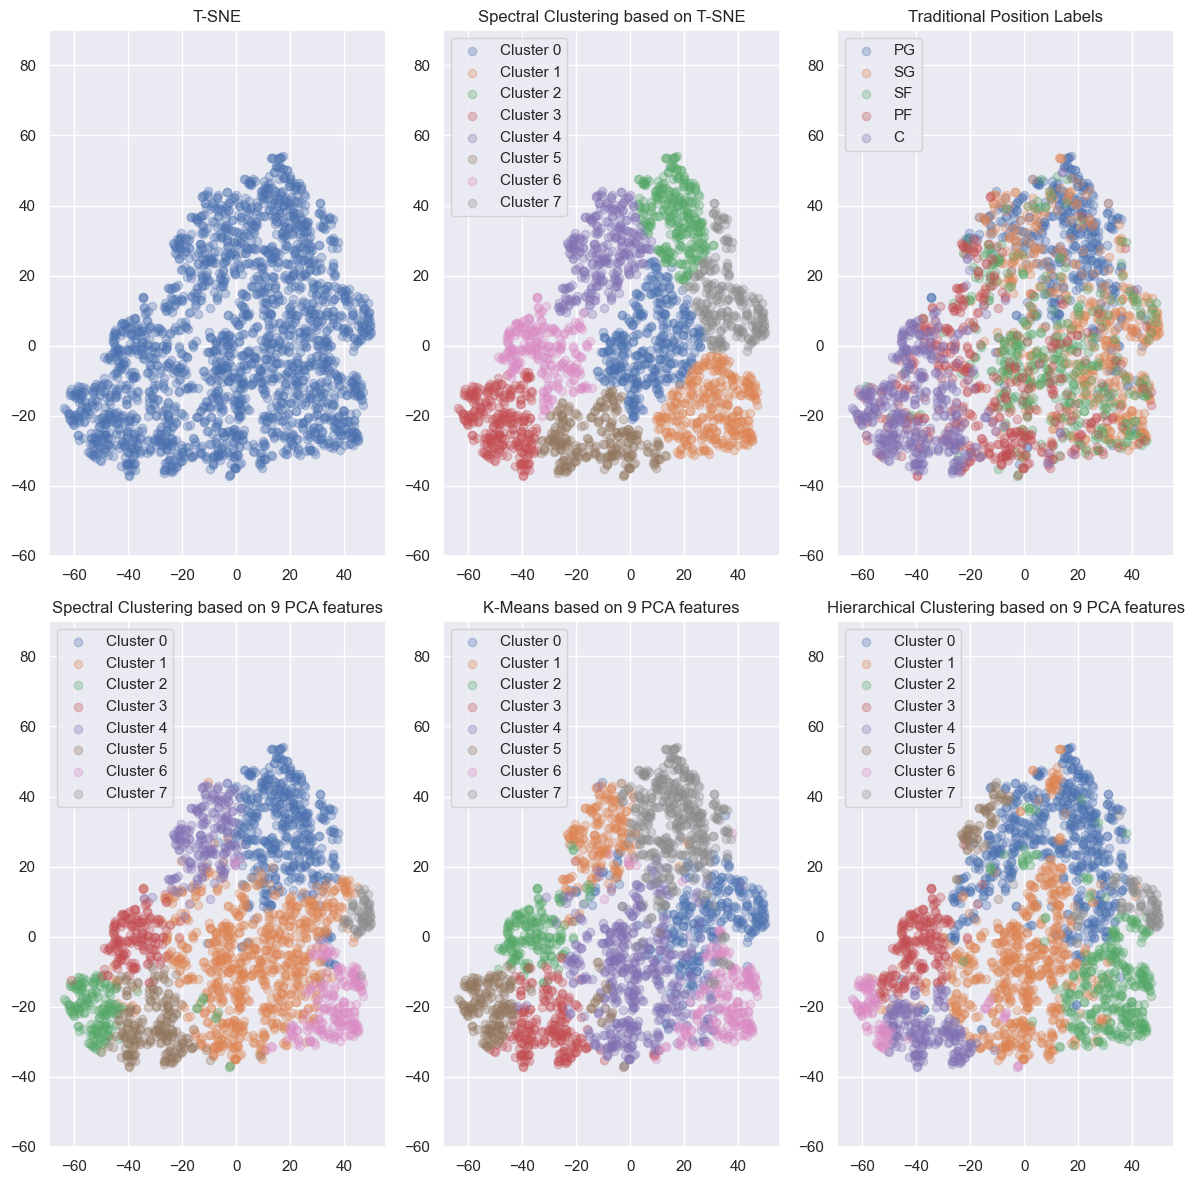

In [81]:
figsize(12, 12)

plt.subplot(2, 3, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title('T-SNE')
plt.ylim(lower_limit, upper_limit)

plt.subplot(2, 3, 2)
for i in range(n_clusters_tsne):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Spectral Clustering based on T-SNE')

plt.subplot(2, 3, 3)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], X_tsne[pos_index, 1], label=pos, alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Traditional Position Labels')

plt.subplot(2, 3, 4)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

plt.subplot(2, 3, 5)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'K-Means based on {n_components} PCA features')

plt.subplot(2, 3, 6)
agc = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean',
                              linkage='ward')
labels = agc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Hierarchical Clustering based on {n_components} PCA features')

plt.tight_layout()

Text(0.5, 1.0, 'Spectral Clustering based on 9 PCA features')

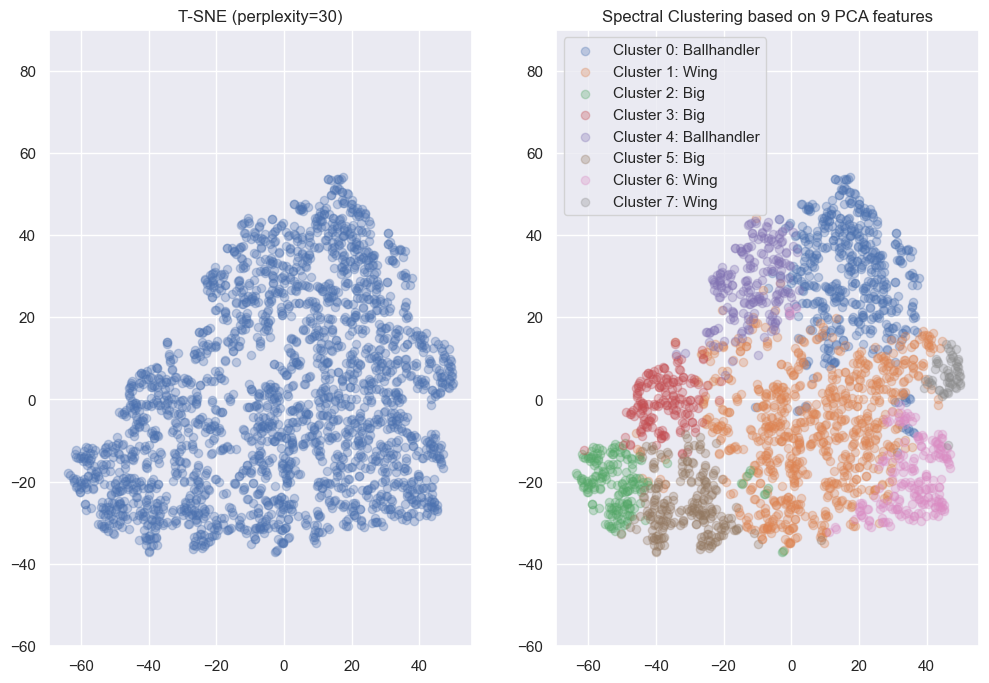

In [82]:
figsize(12, 8)

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title(f'T-SNE (perplexity={perplexity})')
plt.ylim(lower_limit, upper_limit)

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

Text(0.5, 1.0, 'Spectral Clustering based on 9 PCA features')

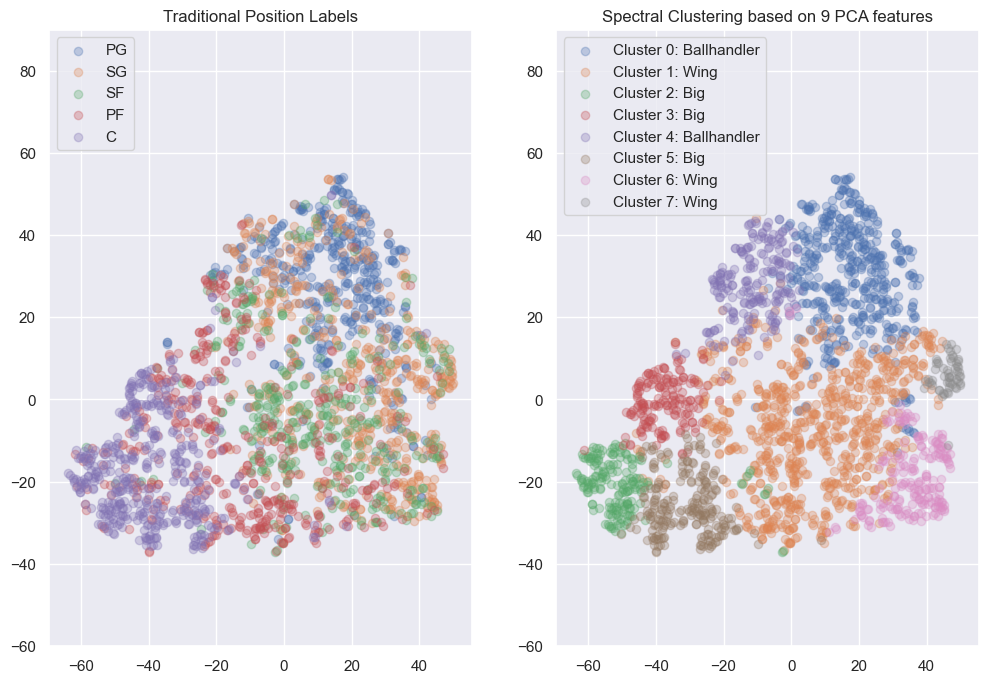

In [85]:
figsize(12, 8)

plt.subplot(1, 2, 1)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], X_tsne[pos_index, 1], label=pos, alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Traditional Position Labels')

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

Text(0.5, 1.0, 'Spectral Clustering based on 9 PCA features')

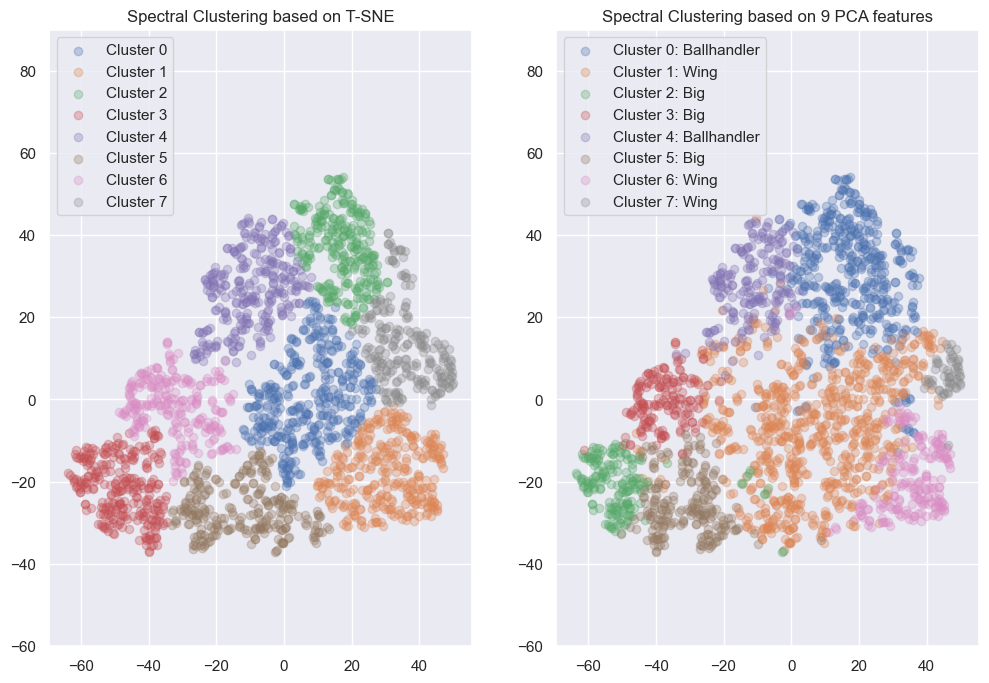

In [87]:
figsize(12, 8)

plt.subplot(1, 2, 1)
for i in range(n_clusters_tsne):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Spectral Clustering based on T-SNE')

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')